<a href="https://colab.research.google.com/github/ivavuko/ivasphd/blob/main/Amplified_and_attenuated_dictionary_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import pandas as pd
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import io
import spacy
from sklearn import metrics
from sklearn.pipeline import Pipeline
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import stats

In [134]:
dictsignals = pd.read_csv("python_signals_dictionary - condensed.csv", encoding="utf-8")
dictsignals.head()

,signals
0,certain items
1,overly
2,100%
3,100 percent
4,absolutely


In [135]:
signals = dictsignals["signals"].tolist()

In [136]:
essays = pd.read_csv("CROSSDA_data_Iva_only_text.xlsx - data_recoded.csv", index_col= "ID", encoding="utf-8")

In [137]:
# converting wildcard signals to regex patterns because of the wildcards from LIWC
regex_patterns = {}
for phrase in signals:
    if phrase.startswith("*") and phrase.endswith("*"):
        regex_patterns[phrase] = rf"\b\w*{re.escape(phrase[1:-1])}\w*\b"
    elif phrase.startswith("*"):
        regex_patterns[phrase] = rf"\b\w*{re.escape(phrase[1:])}\b"
    elif phrase.endswith("*"):
        regex_patterns[phrase] = rf"\b{re.escape(phrase[:-1])}\w*\b"
    else:
        regex_patterns[phrase] = rf"\b{re.escape(phrase)}\b"

In [138]:
# sorting instances by length (longest first) to ensure priority of longer signals
sorted_instances = sorted(regex_patterns.keys(), key=len, reverse=True)

In [139]:
# function for counting the numbers of occurrences of signals in texts
def process_column(df, column_name):
    rows = []

    for index, text in df[column_name].items():
        row = {"Index": index}
        counted_positions = set()  # to track already matched positions

        if pd.isna(text):  # skip nan values
            text = ""

        for phrase in sorted_instances:
            pattern = regex_patterns[phrase]
            matches = list(re.finditer(pattern, text, flags=re.IGNORECASE))
            count = 0

            for match in matches:
                start, end = match.span()
                if all(pos not in counted_positions for pos in range(start, end)):  # ensure no overlap
                    count += 1
                    counted_positions.update(range(start, end))  # mark positions as counted

            row[phrase] = count

        rows.append(row)

    # create the dataframe and set index to match the original dataframe
    return pd.DataFrame(rows).set_index("Index")

In [140]:
# process each column separately
pos_char_signals = process_column(essays, "Personal characteristics POSITIVE")
neg_char_signals = process_column(essays, "Personal characteristics NEGATIVE")
pos_healthcare_signals = process_column(essays, "Universal healthcare POSITIVE")
neg_healthcare_signals = process_column(essays, "Universal healthcare NEGATIVE")

In [141]:
pos_char_signals["ID"] = pos_char_signals.index

Dictionary features based on counts per signal

In [142]:
dictmeta = pd.read_csv("python_signals_dictionary - meta-data.csv", encoding="latin-1")
dictmeta.head()

,signals,subgroup,group
0,certain items,specification,attenuated
1,overly,intensifier,amplified
2,100%,generalization,amplified
3,100 percent,generalization,amplified
4,absolutely,intensifier,amplified


In [143]:
# a function that takes into account the metadata of signals and aggregates signals into the counts of attenuated and amplified language and their subgroups

def aggregate_ngrams_by_subgroup_and_group(ngram_df, dictmeta):

    # create mapping from signal to subgroup
    ngram_to_subgroup = dict(zip(dictmeta["signals"], dictmeta["subgroup"]))

    # filter to valid ngrams that appear in both dictmeta and ngram_df
    valid_ngrams = [col for col in ngram_df.columns if col in ngram_to_subgroup]

    # subset to those columns
    filtered_df = ngram_df[valid_ngrams]

    # create a new df to store subgroup sums
    subgroup_agg = pd.DataFrame(index=filtered_df.index)

    # sum each subgroup
    for subgroup in dictmeta["subgroup"].unique():
        ngrams_in_subgroup = dictmeta[dictmeta["subgroup"] == subgroup]["signals"]
        ngrams_in_subgroup = [ng for ng in ngrams_in_subgroup if ng in filtered_df.columns]
        if ngrams_in_subgroup:
            subgroup_agg[subgroup] = filtered_df[ngrams_in_subgroup].sum(axis=1)
        else:
            subgroup_agg[subgroup] = 0

    # aggregate subgroups into groups
    group_agg = pd.DataFrame(index=subgroup_agg.index)
    group_agg["amplified"] = subgroup_agg.get("generalization", 0) + \
                             subgroup_agg.get("intensifier", 0) + \
                             subgroup_agg.get("certainty", 0)
    group_agg["attenuated"] = subgroup_agg.get("specification", 0) + \
                              subgroup_agg.get("detensifier", 0) + \
                              subgroup_agg.get("uncertainty", 0)

    # combine subgroup and group counts
    result = pd.concat([subgroup_agg, group_agg], axis=1)
    result = result.sort_index(axis=1)

    return result

In [144]:
# a function that normalizes the counts into percentages relative to the word count of that person's text

def normalize_by_column(df, denominator_col="WC"):

    # columns to normalize (all except the denominator)
    cols_to_normalize = df.columns.difference([denominator_col])

    # compute percentages
    percentage = df[cols_to_normalize].div(df[denominator_col], axis=0)*100

     # replace 'inf' values with 0
    percentage.replace([float("inf"), -float("inf")], 0, inplace=True)

    # fill nans (e.g., if denominator is zero) with 0
    percentage = percentage.fillna(0)

    return percentage


In [145]:
essays["WC_pos_char"] = essays["Personal characteristics POSITIVE"].apply(lambda n: len(n.split()) if isinstance(n, str) else 0)
essays["WC_neg_char"] = essays["Personal characteristics NEGATIVE"].apply(lambda n: len(n.split()) if isinstance(n, str) else 0)
essays["WC_health_pos"] = essays["Universal healthcare POSITIVE"].apply(lambda n: len(n.split()) if isinstance(n, str) else 0)
essays["WC_health_neg"] = essays["Universal healthcare NEGATIVE"].apply(lambda n: len(n.split()) if isinstance(n, str) else 0)

In [146]:
pos_char_dict_counts = aggregate_ngrams_by_subgroup_and_group(pos_char_signals, dictmeta)
pos_char_dict_counts = pos_char_dict_counts.join(essays["WC_pos_char"])

## Custom features (the complicated ones that can't be simply counted)



In [147]:
df_good_text = essays.copy()

*Exclamation marks*

In [148]:
df_good_text["exclamation_count_pos_char"] = df_good_text["Personal characteristics POSITIVE"].str.count("!")
df_good_text["exclamation_count_pos_char"].sum()

np.float64(19.0)

In [149]:
df_good_text["exclamation_count_neg_char"] = df_good_text["Personal characteristics NEGATIVE"].str.count("!")
df_good_text["exclamation_count_healthcare_pos"] = df_good_text["Universal healthcare POSITIVE"].str.count("!")
df_good_text["exclamation_count_healthcare_neg"] = df_good_text["Universal healthcare NEGATIVE"].str.count("!")

# *...*

In [150]:
def count_three_dots(text):
    text = str(text)
    three_dots = re.findall(r'\.{3,}', text)
    return len(three_dots)

In [151]:
df_good_text["three_dots_count_pos_char"] = df_good_text["Personal characteristics POSITIVE"].apply(count_three_dots)

In [152]:
df_good_text['three_dots_count_pos_char'].sum()

np.int64(2)

In [153]:
df_good_text['three_dots_count_neg_char'] = df_good_text['Personal characteristics NEGATIVE'].apply(count_three_dots)
df_good_text['three_dots_count_healthcare_pos'] = df_good_text['Universal healthcare POSITIVE'].apply(count_three_dots)
df_good_text['three_dots_count_healthcare_neg'] = df_good_text['Universal healthcare NEGATIVE'].apply(count_three_dots)

*Superlatives*

In [154]:
nlp = spacy.load("en_core_web_sm")

In [155]:
def count_superlatives(text):
    if pd.isna(text):
        return 0
    doc = nlp(text)
    return sum(1 for token in doc if token.tag_ in ("JJS", "RBS"))

In [156]:
for col in ["Personal characteristics POSITIVE", "Personal characteristics NEGATIVE", "Universal healthcare POSITIVE", "Universal healthcare NEGATIVE"]:
    df_good_text[f'{col}_superlatives'] = df_good_text[col].apply(count_superlatives)

*CAPSed words*

In [157]:
# exclude texts where everything is in caps and when a word in caps is an abbreviation
# if two words are in caps, like "EXTREMELLY GOOD coffee", count it as the occurence of 1

In [158]:
import re

In [159]:
# function that counts CAPSed words while excluding potential abbreviations (i.e., words with 4 or less characters)

def count_capslock(text):
    if not isinstance(text, str) or not text.strip():
        return 0

    # ignore if the whole text is in CAPS
    if text.isupper():
        return 0

    words = text.split()
    count = 0
    prev_caps = False

    for word in words:
        # clean punctuation around the word
        clean_word = re.sub(r'[^A-Z]', '', word)

        # check if it's a potential abbreviation (short, ≤4 letters, all caps)
        is_abbreviation = clean_word.isupper() and len(clean_word) <= 4

        # count if word is CAPSed and not an abbreviation
        if word.isupper() and not is_abbreviation:
            if not prev_caps:
                count += 1
                prev_caps = True
        else:
            prev_caps = False

    return count


In [160]:
for col in ["Personal characteristics POSITIVE", "Personal characteristics NEGATIVE", "Universal healthcare POSITIVE", "Universal healthcare NEGATIVE"]:
    df_good_text[f'{col}_caps'] = df_good_text[col].apply(count_capslock)

*POS tagging*

In [161]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import sent_tokenize, word_tokenize, pos_tag

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [162]:
def get_pos_tags(text):
    if pd.isna(text):
        return None
    tagged_sentences = []
    for sent in sent_tokenize(text):
        tokens = word_tokenize(sent)
        tags = pos_tag(tokens)
        tagged_sentences.append(tags)
    return tagged_sentences

In [163]:
df_good_text["POS_tags_pos_char"] = df_good_text["Personal characteristics POSITIVE"].apply(get_pos_tags)

In [164]:
df_good_text["POS_tags_neg_char"] = df_good_text["Personal characteristics NEGATIVE"].apply(get_pos_tags)

In [165]:
df_good_text["POS_tags_health_pos"] = df_good_text["Universal healthcare POSITIVE"].apply(get_pos_tags)

In [166]:
df_good_text["POS_tags_health_neg"] = df_good_text["Universal healthcare NEGATIVE"].apply(get_pos_tags)

*SAME ADJ and SAME ADJ*

In [167]:
#search for ("anyword", 'ADJ') followed by ("anyword", 'ADJ')

In [168]:
def count_repeated_adj(tags):
    if tags is None:
        return 0

    count = 0
    for sent in tags:
        for i in range(len(sent) - 2):
            w1, p1 = sent[i]
            w2, p2 = sent[i+1]
            w3, p3 = sent[i+2]

            if p1.startswith("JJ") and p3.startswith("JJ") and w1.lower() == w3.lower() and w2.lower() == "and":
                count += 1
    return count

In [169]:
df_good_text["pos_char_repeated_adj"] = df_good_text["POS_tags_pos_char"].apply(count_repeated_adj)

In [170]:
df_good_text["neg_char_repeated_adj"] = df_good_text["POS_tags_neg_char"].apply(count_repeated_adj)
df_good_text["health_pos_repeated_adj"] = df_good_text["POS_tags_health_pos"].apply(count_repeated_adj)
df_good_text["health_neg_repeated_adj"] = df_good_text["POS_tags_health_neg"].apply(count_repeated_adj)

*at ADJ times*

In [171]:
#search for ("at", 'IN'), ("anyword", 'ADJ'), ("times", 'NOUN')

In [172]:
def count_at_adj_times(tags):
    if tags is None:
        return 0

    count = 0
    for sent in tags:
        for i in range(len(sent) - 2):
            w1, p1 = sent[i]
            w2, p2 = sent[i+1]
            w3, p3 = sent[i+2]

            if w1.lower() == "at" and p1 == ("IN") and p2 == ("JJ") and w3.lower() == "times" and p3 == "NOUN":
                count += 1
    return count

In [173]:
df_good_text["pos_char_at_adj_times"] = df_good_text["POS_tags_pos_char"].apply(count_at_adj_times)

In [174]:
df_good_text["neg_char_at_adj_times"] = df_good_text["POS_tags_neg_char"].apply(count_at_adj_times)
df_good_text["health_pos_at_adj_times"] = df_good_text["POS_tags_health_pos"].apply(count_at_adj_times)
df_good_text["health_neg_at_adj_times"] = df_good_text["POS_tags_health_neg"].apply(count_at_adj_times)

In [175]:
df_good_text.to_csv("df_good_text.csv")

In [176]:
#rename
df_good_text = df_good_text.rename(columns={"Personal characteristics POSITIVE_superlatives" : "superlatives_pos_char",
                            "Personal characteristics NEGATIVE_superlatives" : "superlatives_neg_char",
                             "Universal healthcare POSITIVE_superlatives" : "superlatives_healthcare_pos",
                             "Universal healthcare NEGATIVE_superlatives": "superlatives_healthcare_neg",
                                            "Personal characteristics POSITIVE_caps" : "caps_pos_char",
                                            "Personal characteristics NEGATIVE_caps" : "caps_neg_char",
                                           "Universal healthcare POSITIVE_caps" : "caps_health_pos",
                                             "Universal healthcare NEGATIVE_caps" : "caps_health_neg"})


In [177]:
#add those features to the dict (sum them in the total count)

# add exlamation_count, superlatives, CAPSed words, SAME and SAME ADJ to intensifiers and amplified
# add three_doct_count to detensifiers and attenuated
# add at ADJ times to specification and attenuated

In [178]:
new_pos_char = df_good_text[["exclamation_count_pos_char", "three_dots_count_pos_char", "superlatives_pos_char", "caps_pos_char", "pos_char_at_adj_times", "pos_char_repeated_adj"]]
new_neg_char = df_good_text[["exclamation_count_neg_char", "three_dots_count_neg_char", "superlatives_neg_char", "caps_neg_char", "neg_char_at_adj_times", "neg_char_repeated_adj"]]
new_healthcare_pos = df_good_text[["exclamation_count_healthcare_pos", "three_dots_count_healthcare_pos", "superlatives_healthcare_pos", "caps_health_pos", "health_pos_at_adj_times", "health_pos_repeated_adj"]]
new_healthcare_neg = df_good_text[["exclamation_count_healthcare_neg", "three_dots_count_healthcare_neg", "superlatives_healthcare_neg", "caps_health_neg", "health_neg_at_adj_times", "health_neg_repeated_adj"]]

In [179]:
pos_char_all_features = pd.concat([new_pos_char, pos_char_dict_counts], axis=1, join="inner")

In [180]:
# add exclamation_count_pos_char and superlatives_pos_char to intensifier and amplified
pos_char_all_features["intensifier"] = pos_char_all_features["intensifier"] + pos_char_all_features["exclamation_count_pos_char"] + pos_char_all_features["superlatives_pos_char"] + pos_char_all_features["caps_pos_char"] + pos_char_all_features["pos_char_repeated_adj"]
pos_char_all_features["amplified"] = pos_char_all_features["amplified"] + pos_char_all_features["exclamation_count_pos_char"] + pos_char_all_features["superlatives_pos_char"] + pos_char_all_features["caps_pos_char"] + pos_char_all_features["pos_char_repeated_adj"]

# add three_dots_count_pos_char and ish_pos_char to detensifier and attenuated
pos_char_all_features["detensifier"] = pos_char_all_features["detensifier"] + pos_char_all_features["three_dots_count_pos_char"]
pos_char_all_features["attenuated"] = pos_char_all_features["attenuated"] + pos_char_all_features["three_dots_count_pos_char"]

# add at adj times to specification and attenuated
pos_char_all_features["specification"] = pos_char_all_features["specification"] + pos_char_all_features["pos_char_at_adj_times"]
pos_char_all_features["attenuated"] = pos_char_all_features["attenuated"] + pos_char_all_features["pos_char_at_adj_times"]

In [181]:
pos_char_all_features = pos_char_all_features.drop(columns=["exclamation_count_pos_char", "three_dots_count_pos_char", "superlatives_pos_char", "caps_pos_char", "pos_char_repeated_adj", "pos_char_at_adj_times"])

neg char dictionary

In [182]:
neg_char_dict_counts = aggregate_ngrams_by_subgroup_and_group(neg_char_signals, dictmeta)
neg_char_dict_counts = neg_char_dict_counts.join(essays["WC_neg_char"])

In [183]:
neg_char_all_features = pd.concat([new_neg_char, neg_char_dict_counts], axis=1, join="inner")

In [184]:
neg_char_all_features["intensifier"] = neg_char_all_features["intensifier"] + neg_char_all_features["exclamation_count_neg_char"] + neg_char_all_features["superlatives_neg_char"] + neg_char_all_features["caps_neg_char"] + neg_char_all_features["neg_char_repeated_adj"]
neg_char_all_features["amplified"] = neg_char_all_features["amplified"] + neg_char_all_features["exclamation_count_neg_char"] + neg_char_all_features["superlatives_neg_char"]  + neg_char_all_features["caps_neg_char"] + neg_char_all_features["neg_char_repeated_adj"]

neg_char_all_features["detensifier"] = neg_char_all_features["detensifier"] + neg_char_all_features["three_dots_count_neg_char"]
neg_char_all_features["attenuated"] = neg_char_all_features["attenuated"] + neg_char_all_features["three_dots_count_neg_char"]

neg_char_all_features["specification"] = neg_char_all_features["specification"] + neg_char_all_features["neg_char_at_adj_times"]
neg_char_all_features["attenuated"] = neg_char_all_features["attenuated"] + neg_char_all_features["neg_char_at_adj_times"]

In [185]:
neg_char_all_features = neg_char_all_features.drop(columns=["exclamation_count_neg_char", "three_dots_count_neg_char", "superlatives_neg_char", "caps_neg_char", "neg_char_repeated_adj", "neg_char_at_adj_times"])

universal healthcare positive

In [186]:
pos_healthcare_dict_counts = aggregate_ngrams_by_subgroup_and_group(pos_healthcare_signals, dictmeta)
pos_healthcare_dict_counts = pos_healthcare_dict_counts.join(essays["WC_health_pos"])

In [187]:
health_pos_all_features = pd.concat([new_healthcare_pos, pos_healthcare_dict_counts], axis=1, join="inner")

In [188]:
health_pos_all_features["intensifier"] = health_pos_all_features["intensifier"] + health_pos_all_features["exclamation_count_healthcare_pos"] + health_pos_all_features["superlatives_healthcare_pos"] + health_pos_all_features["caps_health_pos"] + health_pos_all_features["health_pos_repeated_adj"]
health_pos_all_features["amplified"] = health_pos_all_features["amplified"] + health_pos_all_features["exclamation_count_healthcare_pos"] + health_pos_all_features["superlatives_healthcare_pos"] + health_pos_all_features["caps_health_pos"] + health_pos_all_features["health_pos_repeated_adj"]

health_pos_all_features["detensifier"] = health_pos_all_features["detensifier"] + health_pos_all_features["three_dots_count_healthcare_pos"]
health_pos_all_features["attenuated"] = health_pos_all_features["attenuated"] + health_pos_all_features["three_dots_count_healthcare_pos"]

health_pos_all_features["specification"] = health_pos_all_features["specification"] + health_pos_all_features["health_pos_at_adj_times"]
health_pos_all_features["attenuated"] = health_pos_all_features["attenuated"] + health_pos_all_features["health_pos_at_adj_times"]

In [189]:
health_pos_all_features = health_pos_all_features.drop(columns=["exclamation_count_healthcare_pos", "three_dots_count_healthcare_pos", "superlatives_healthcare_pos", "caps_health_pos", "health_pos_repeated_adj", "health_pos_at_adj_times"])

universal healthcare negative

In [190]:
neg_healthcare_dict_counts = aggregate_ngrams_by_subgroup_and_group(neg_healthcare_signals, dictmeta)
neg_healthcare_dict_counts = neg_healthcare_dict_counts.join(essays["WC_health_neg"])

In [191]:
health_neg_all_features = pd.concat([new_healthcare_neg, neg_healthcare_dict_counts], axis=1, join="inner")

In [192]:
health_neg_all_features["intensifier"] = health_neg_all_features["intensifier"] + health_neg_all_features["exclamation_count_healthcare_neg"] + health_neg_all_features["superlatives_healthcare_neg"] + health_neg_all_features["caps_health_neg"] + health_neg_all_features["health_neg_repeated_adj"]
health_neg_all_features['amplified'] = health_neg_all_features["amplified"] + health_neg_all_features["exclamation_count_healthcare_neg"] + health_neg_all_features["superlatives_healthcare_neg"] + health_neg_all_features["caps_health_neg"] + health_neg_all_features["health_neg_repeated_adj"]

health_neg_all_features["detensifier"] = health_neg_all_features["detensifier"] + health_neg_all_features["three_dots_count_healthcare_neg"]
health_neg_all_features["attenuated"] = health_neg_all_features["attenuated"] + health_neg_all_features["three_dots_count_healthcare_neg"]

health_neg_all_features["specification"] = health_neg_all_features["specification"] + health_neg_all_features["health_neg_at_adj_times"]
health_neg_all_features["attenuated"] = health_neg_all_features["attenuated"] + health_neg_all_features["health_neg_at_adj_times"]

In [193]:
health_neg_all_features = health_neg_all_features.drop(columns=["exclamation_count_healthcare_neg", "three_dots_count_healthcare_neg", "superlatives_healthcare_neg", "caps_health_neg", "health_neg_repeated_adj", "health_neg_at_adj_times"])

Normalized dictionary features

In [194]:
pos_char_dict = normalize_by_column(pos_char_all_features, denominator_col="WC_pos_char")

In [195]:
neg_char_dict = normalize_by_column(neg_char_all_features, denominator_col="WC_neg_char")

In [196]:
pos_healthcare_dict = normalize_by_column(health_pos_all_features, denominator_col="WC_health_pos")

In [197]:
neg_healthcare_dict = normalize_by_column(health_neg_all_features, denominator_col="WC_health_neg")

Rename signals

In [198]:
pos_char_signals = pos_char_signals.drop(columns = ["ID"])

In [199]:
pos_char_signals = pos_char_signals.add_suffix("_pos_char")
neg_char_signals = neg_char_signals.add_suffix("_neg_char")

In [200]:
pos_healthcare_signals = pos_healthcare_signals.add_suffix("_pos_healthcare")
neg_healthcare_signals = neg_healthcare_signals.add_suffix("_neg_healthcare")

In [201]:
df_signals = pd.concat([pos_char_signals, neg_char_signals, pos_healthcare_signals, neg_healthcare_signals], axis=1, join="inner")

rename dictionary

In [202]:
pos_char_dict = pos_char_dict.add_suffix("_dict_pos_char")
neg_char_dict = neg_char_dict.add_suffix("_dict_neg_char")
pos_healthcare_dict = pos_healthcare_dict.add_suffix("_dict_pos_healthcare")
neg_healthcare_dict = neg_healthcare_dict.add_suffix("_dict_neg_healthcare")

In [203]:
df_dict = pd.concat([pos_char_dict, neg_char_dict, pos_healthcare_dict, neg_healthcare_dict], axis=1, join="inner")

In [204]:
df_dict.head()

,amplified_dict_pos_char,attenuated_dict_pos_char,certainty_dict_pos_char,detensifier_dict_pos_char,generalization_dict_pos_char,intensifier_dict_pos_char,specification_dict_pos_char,uncertainty_dict_pos_char,amplified_dict_neg_char,attenuated_dict_neg_char,...,specification_dict_pos_healthcare,uncertainty_dict_pos_healthcare,amplified_dict_neg_healthcare,attenuated_dict_neg_healthcare,certainty_dict_neg_healthcare,detensifier_dict_neg_healthcare,generalization_dict_neg_healthcare,intensifier_dict_neg_healthcare,specification_dict_neg_healthcare,uncertainty_dict_neg_healthcare
6716638eb68bb8ffd91a564d,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
675c63b9b4283bc639a84666,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
67606dd306bf1a14a332f78b,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
674167869d64d2b4fc734165,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
63ea6e6d78fced1e97a149c8,5.945946,4.864865,0.0,0.0,1.621622,4.324324,2.162162,2.702703,3.626943,7.772021,...,0.641026,5.128205,1.104972,8.287293,0.0,0.0,1.104972,0.0,1.104972,7.18232


Merge all text features

In [205]:
df_lang_features = pd.concat([df_dict, df_signals], axis=1)

Merge with the survey dataframe and leave only data of quality

In [206]:
survey = pd.read_excel("CROSSDA_data_Iva.xlsx", index_col= "ID", engine="openpyxl")

In [207]:
df_all = pd.concat([survey, df_lang_features], axis=1)

In [208]:
df_good = df_all[
    df_all["IPIP120_120.r"].notna() &
    df_all["attention_check"].isin(["PASS", "MIXED"]) &
    (df_all["num_answers"] == 4) &
    ~df_all["ivas_verdict_REFRESHIT"].isin(["gpt", "gpt pitaj", "gpt/ full", "maybe", "yes"])
]

In [209]:
df_good[["attenuated_dict_pos_char", "attenuated_dict_neg_char", "amplified_dict_pos_char", "amplified_dict_neg_char"]].describe()

,attenuated_dict_pos_char,attenuated_dict_neg_char,amplified_dict_pos_char,amplified_dict_neg_char
count,377.000000,377.000000,377.000000,377.000000
mean,3.614204,7.641107,3.810133,2.856383
std,2.637457,3.938601,2.651928,2.177023
min,0.000000,0.000000,0.000000,0.000000
25%,1.762115,5.000000,1.851852,1.388889
50%,3.243243,7.185629,3.529412,2.590674
75%,5.208333,10.000000,5.228758,3.846154
max,12.154696,27.272727,13.043478,17.647059


In [210]:
df_good[["neg_in_pos_num", "pos_in_neg_num"]] = df_good[["neg_in_pos_num", "pos_in_neg_num"]].fillna(0)


/tmp/ipython-input-1432441184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good[["neg_in_pos_num", "pos_in_neg_num"]] = df_good[["neg_in_pos_num", "pos_in_neg_num"]].fillna(0)


Controling for general use: Target - avg of controls

In [211]:
df_good[["attenuated_dict_pos_healthcare", "attenuated_dict_neg_healthcare", "amplified_dict_pos_healthcare", "amplified_dict_neg_healthcare"]].describe()

,attenuated_dict_pos_healthcare,attenuated_dict_neg_healthcare,amplified_dict_pos_healthcare,amplified_dict_neg_healthcare
count,377.000000,377.000000,377.000000,377.000000
mean,3.606615,6.010917,2.789483,1.857304
std,2.644919,3.081090,2.314282,1.899313
min,0.000000,0.000000,0.000000,0.000000
25%,1.550388,4.000000,1.250000,0.000000
50%,3.448276,5.825243,2.343750,1.562500
75%,5.357143,7.692308,3.875969,2.958580
max,12.500000,16.129032,14.285714,14.285714


In [212]:
df_good["attenuated_dict_healthcare_avg"] = (df_good["attenuated_dict_pos_healthcare"] + df_good["attenuated_dict_neg_healthcare"]) / 2

/tmp/ipython-input-1206139576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good["attenuated_dict_healthcare_avg"] = (df_good["attenuated_dict_pos_healthcare"] + df_good["attenuated_dict_neg_healthcare"]) / 2


In [213]:
df_good["amplified_dict_healthcare_avg"] = (df_good["amplified_dict_pos_healthcare"] + df_good["amplified_dict_neg_healthcare"]) / 2

/tmp/ipython-input-3888497388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good["amplified_dict_healthcare_avg"] = (df_good["amplified_dict_pos_healthcare"] + df_good["amplified_dict_neg_healthcare"]) / 2


In [214]:
df_good["generalization_dict_healthcare_avg"] = (df_good["generalization_dict_pos_healthcare"] + df_good["generalization_dict_neg_healthcare"]) / 2
df_good["certainty_dict_healthcare_avg"] = (df_good["certainty_dict_pos_healthcare"] + df_good["certainty_dict_neg_healthcare"]) / 2
df_good["intensifier_dict_healthcare_avg"] = (df_good["intensifier_dict_pos_healthcare"] + df_good["intensifier_dict_neg_healthcare"]) / 2
df_good["specification_dict_healthcare_avg"] = (df_good["specification_dict_pos_healthcare"] + df_good["specification_dict_neg_healthcare"]) / 2
df_good["detensifier_dict_healthcare_avg"] = (df_good["detensifier_dict_pos_healthcare"] + df_good["detensifier_dict_neg_healthcare"]) / 2
df_good["uncertainty_dict_healthcare_avg"] = (df_good["uncertainty_dict_pos_healthcare"] + df_good["uncertainty_dict_neg_healthcare"]) / 2

/tmp/ipython-input-2550090087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good["generalization_dict_healthcare_avg"] = (df_good["generalization_dict_pos_healthcare"] + df_good["generalization_dict_neg_healthcare"]) / 2
/tmp/ipython-input-2550090087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good["certainty_dict_healthcare_avg"] = (df_good["certainty_dict_pos_healthcare"] + df_good["certainty_dict_neg_healthcare"]) / 2
/tmp/ipython-input-2550090087.py:3: SettingWithCopyWarning: 
A valu

In [215]:
df_good["amplified_dict_pos_char_control"] = df_good["amplified_dict_pos_char"] - df_good["amplified_dict_healthcare_avg"]
df_good["amplified_dict_neg_char_control"] = df_good["amplified_dict_neg_char"] - df_good["amplified_dict_healthcare_avg"]
df_good["attenuated_dict_pos_char_control"] = df_good["attenuated_dict_pos_char"] - df_good["attenuated_dict_healthcare_avg"]
df_good["attenuated_dict_neg_char_control"] = df_good["attenuated_dict_neg_char"] - df_good["attenuated_dict_healthcare_avg"]

/tmp/ipython-input-1817407185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good["amplified_dict_pos_char_control"] = df_good["amplified_dict_pos_char"] - df_good["amplified_dict_healthcare_avg"]
/tmp/ipython-input-1817407185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good["amplified_dict_neg_char_control"] = df_good["amplified_dict_neg_char"] - df_good["amplified_dict_healthcare_avg"]
/tmp/ipython-input-1817407185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [216]:
df_good["generalization_dict_pos_char_control"] = df_good["generalization_dict_pos_char"] - df_good["generalization_dict_healthcare_avg"]
df_good["intensifier_dict_pos_char_control"] = df_good["intensifier_dict_pos_char"] - df_good["intensifier_dict_healthcare_avg"]
df_good["certainty_dict_pos_char_control"] = df_good["certainty_dict_pos_char"] - df_good["certainty_dict_healthcare_avg"]

df_good["generalization_dict_neg_char_control"] = df_good["generalization_dict_neg_char"] - df_good["generalization_dict_healthcare_avg"]
df_good["intensifier_dict_neg_char_control"] = df_good["intensifier_dict_neg_char"] - df_good["intensifier_dict_healthcare_avg"]
df_good["certainty_dict_neg_char_control"] = df_good["certainty_dict_neg_char"] - df_good["certainty_dict_healthcare_avg"]

df_good["specification_dict_pos_char_control"] = df_good["specification_dict_pos_char"] - df_good["specification_dict_healthcare_avg"]
df_good["detensifier_dict_pos_char_control"] = df_good["detensifier_dict_pos_char"] - df_good["detensifier_dict_healthcare_avg"]
df_good["uncertainty_dict_pos_char_control"] = df_good["uncertainty_dict_pos_char"] - df_good["uncertainty_dict_healthcare_avg"]

df_good["specification_dict_neg_char_control"] = df_good["specification_dict_neg_char"] - df_good["specification_dict_healthcare_avg"]
df_good["detensifier_dict_neg_char_control"] = df_good["detensifier_dict_neg_char"] - df_good["detensifier_dict_healthcare_avg"]
df_good["uncertainty_dict_neg_char_control"] = df_good["uncertainty_dict_neg_char"] - df_good["uncertainty_dict_healthcare_avg"]

/tmp/ipython-input-2064350137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good["generalization_dict_pos_char_control"] = df_good["generalization_dict_pos_char"] - df_good["generalization_dict_healthcare_avg"]
/tmp/ipython-input-2064350137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good["intensifier_dict_pos_char_control"] = df_good["intensifier_dict_pos_char"] - df_good["intensifier_dict_healthcare_avg"]
/tmp/ipython-input-2064350137.py:3: SettingWithCopyWarning: 
A value is trying to

In [217]:
df_good.to_csv("df_good.csv")

Descriptive analyses and plotting

In [218]:
#plot 4 distributions

# amplified pos

ampl_pos = df_good["amplified_dict_pos_char_control"]
ampl_pos.describe()

,amplified_dict_pos_char_control
count,377.000000
mean,1.486739
std,2.824383
min,-5.336208
25%,-0.374383
50%,1.209261
75%,3.073252
max,13.043478


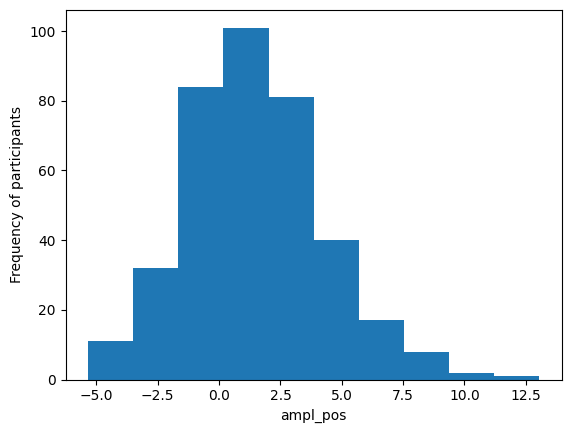

In [219]:
plt.hist(ampl_pos)
plt.ylabel("Frequency of participants")
plt.xlabel("ampl_pos")
plt.show()

In [220]:
# amplified pos chat

ampl_neg = df_good["amplified_dict_neg_char_control"]
ampl_neg.describe()

,amplified_dict_neg_char_control
count,377.000000
mean,0.532989
std,2.536471
min,-7.007168
25%,-0.955746
50%,0.308642
75%,1.785714
max,17.647059


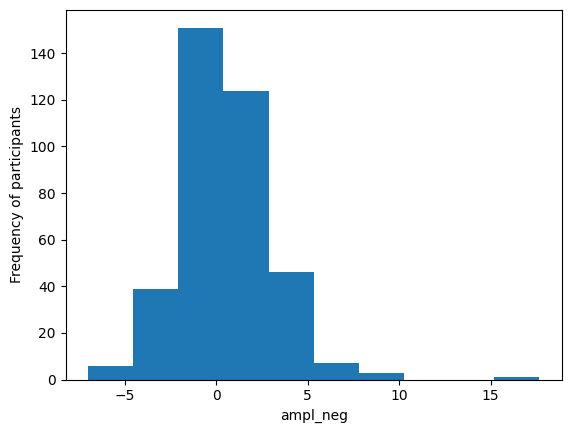

In [221]:
plt.hist(ampl_neg)
plt.ylabel("Frequency of participants")
plt.xlabel("ampl_neg")
plt.show()

In [222]:
# attenuated pos char

atten_pos = df_good["attenuated_dict_pos_char_control"]
atten_pos.describe()

,attenuated_dict_pos_char_control
count,377.000000
mean,-1.194562
std,3.119761
min,-9.085842
25%,-3.260431
50%,-1.311722
75%,0.801115
max,9.317170


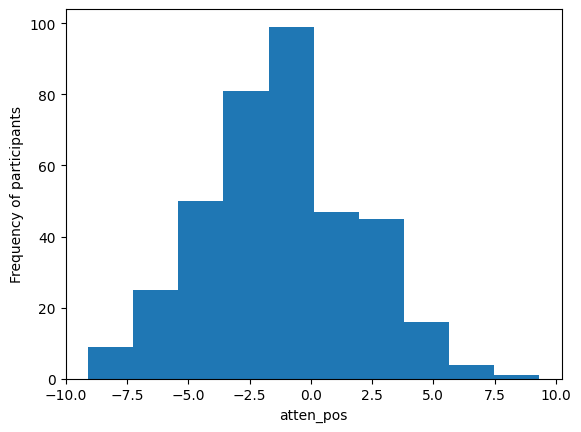

In [223]:
plt.hist(atten_pos)
plt.ylabel("Frequency of participants")
plt.xlabel("atten_pos")
plt.show()

In [224]:
# attenuated neg char

atten_neg = df_good["attenuated_dict_neg_char_control"]
atten_neg.describe()

,attenuated_dict_neg_char_control
count,377.000000
mean,2.832341
std,4.155110
min,-8.673469
25%,0.233994
50%,2.473193
75%,4.979592
max,24.772727


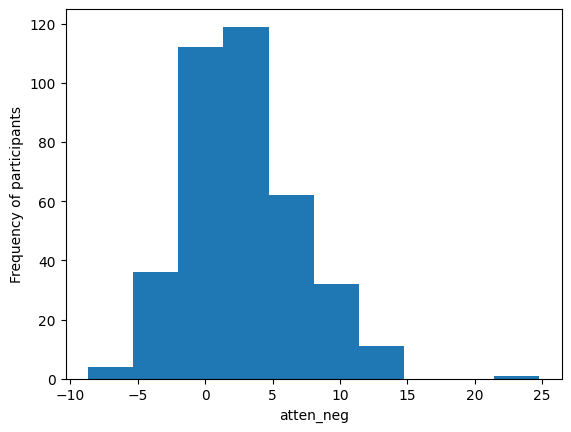

In [225]:
plt.hist(atten_neg)
plt.ylabel("Frequency of participants")
plt.xlabel("atten_neg")
plt.show()

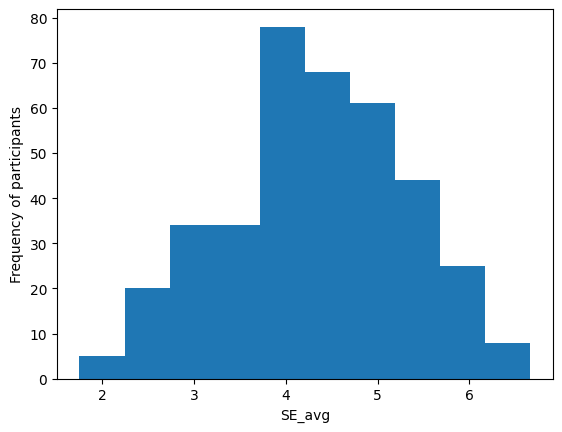

In [226]:
SE_avg = df_good["SE_avg"]
plt.hist(SE_avg)
plt.ylabel("Frequency of participants")
plt.xlabel("SE_avg")
plt.show()

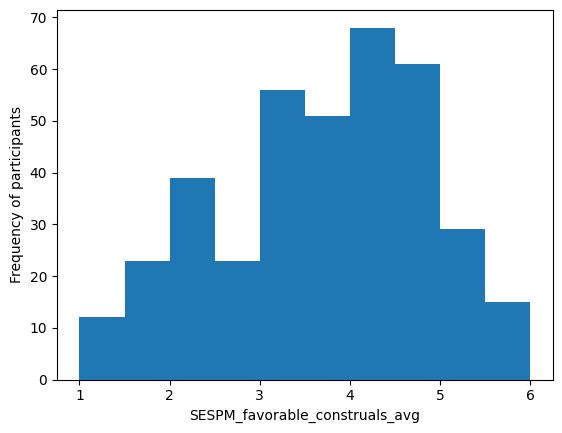

In [227]:
SESPM_favorable_construals_avg = df_good["SESPM_favorable_construals_avg"]
plt.hist(SESPM_favorable_construals_avg)
plt.ylabel("Frequency of participants")
plt.xlabel("SESPM_favorable_construals_avg")
plt.show()

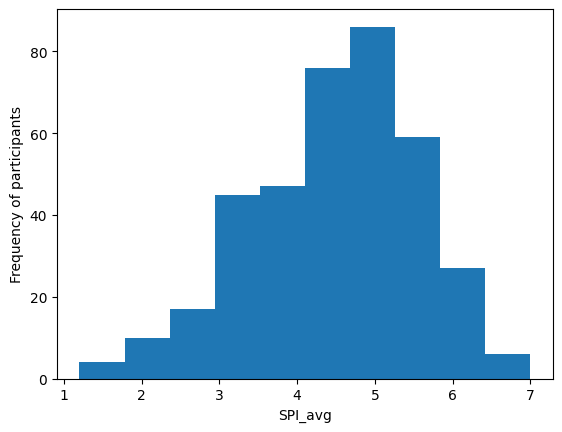

In [228]:
SPI_avg = df_good["SPI_avg"]
plt.hist(SPI_avg)
plt.ylabel("Frequency of participants")
plt.xlabel("SPI_avg")
plt.show()

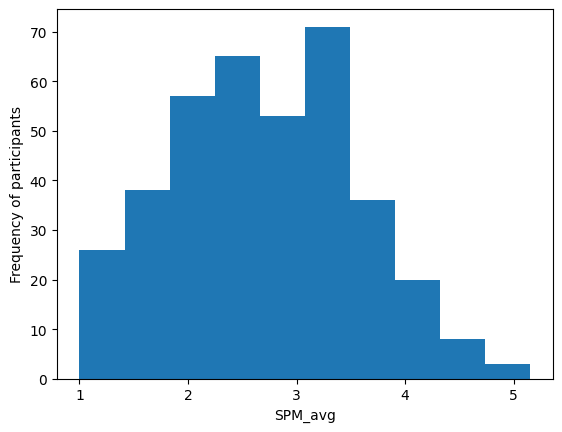

In [229]:
SPM_avg = df_good["SPM_avg"]
plt.hist(SPM_avg)
plt.ylabel("Frequency of participants")
plt.xlabel("SPM_avg")
plt.show()

In [230]:
ext  = df_good["extraversion_avg"]

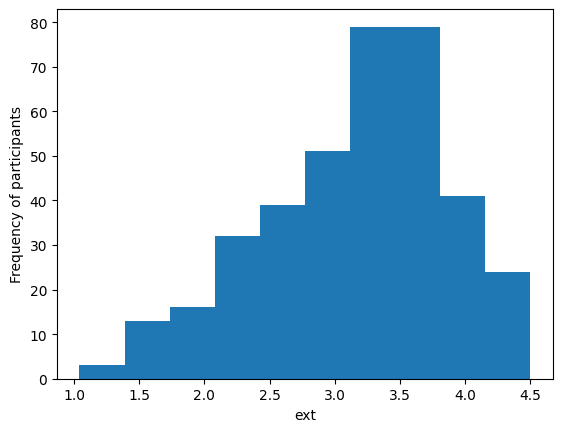

In [231]:
plt.hist(ext)
plt.ylabel("Frequency of participants")
plt.xlabel("ext")
plt.show()

In [232]:
dep = df_good["DASS21_dep_sum"]
dep.describe()

,DASS21_dep_sum
count,377.000000
mean,11.161804
std,6.153431
min,1.000000
25%,7.000000
50%,9.000000
75%,15.000000
max,28.000000


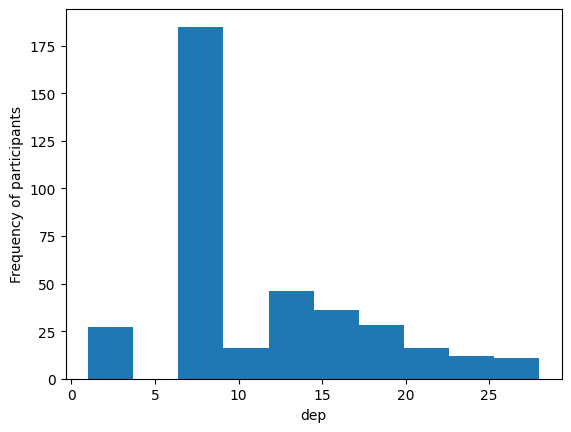

In [233]:
plt.hist(dep)
plt.ylabel("Frequency of participants")
plt.xlabel("dep")
plt.show()

In [234]:
sise = df_good["SISE"]
sise.describe()

,SISE
count,377.000000
mean,4.811671
std,1.954012
min,1.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,7.000000


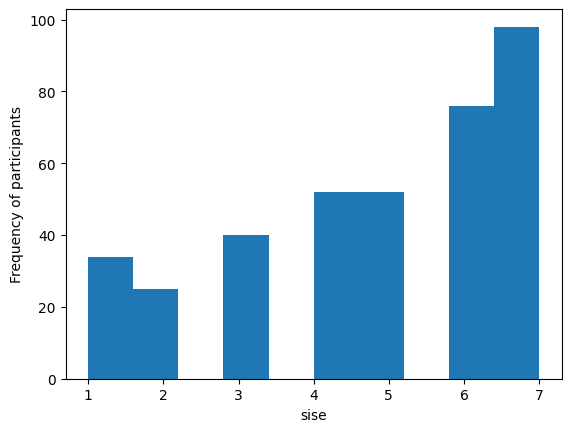

In [235]:
plt.hist(sise)
plt.ylabel("Frequency of participants")
plt.xlabel("sise")
plt.show()

In [236]:
sar = df_good["SESPM_self.affirming_reflections_avg"]
sar.describe()

,SESPM_self.affirming_reflections_avg
count,377.000000
mean,4.457992
std,0.976347
min,1.000000
25%,3.833000
50%,4.666667
75%,5.167000
max,6.000000


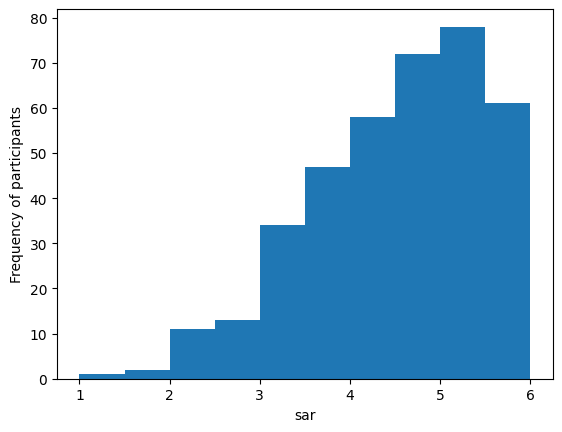

In [237]:
plt.hist(sar)
plt.ylabel("Frequency of participants")
plt.xlabel("sar")
plt.show()

In [238]:
from scipy.stats import skew

print(skew(dep))
print(skew(ext))
print(skew(ampl_neg))
print(skew(ampl_pos))
print(skew(atten_neg))
print(skew(atten_pos))

0.7839960869185537
-0.5646210035000149
1.0775637406330143
0.5087532368106394
0.7138217891075347
0.1340617334928362


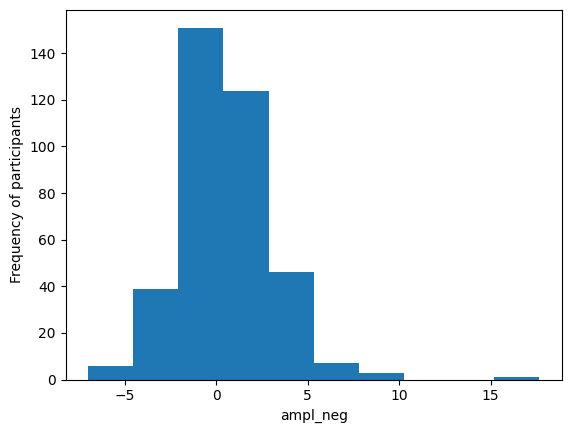

In [239]:
plt.hist(ampl_neg)
plt.ylabel("Frequency of participants")
plt.xlabel("ampl_neg")
plt.show()

In [240]:
RME = df_good["Rosenberg_avg"]
RME.describe()

,Rosenberg_avg
count,377.000000
mean,2.924138
std,0.783117
min,1.000000
25%,2.400000
50%,3.000000
75%,3.600000
max,4.000000


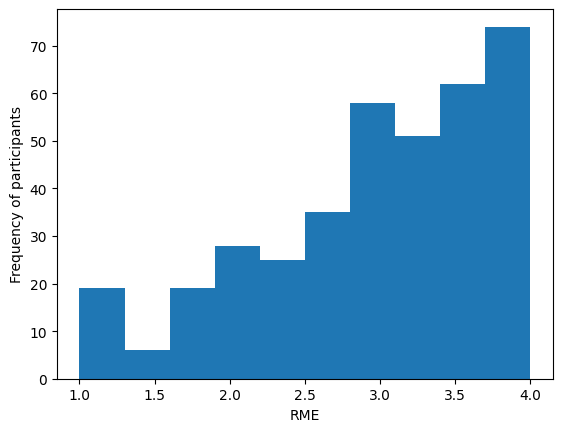

In [241]:
plt.hist(RME)
plt.ylabel("Frequency of participants")
plt.xlabel("RME")
plt.show()

In [242]:
print(skew(RME))

-0.6742182596921971


# *Cronbach alpha*

In [243]:
SE_all = df_good[["SE01.r", "SE02", "SE03.r", "SE04", "SE05.r", "SE06", "SE07.r", "SE08", "SE09.r", "SE10", "SE11", "SE12.r"]]

In [244]:
 ext_all = df_good[["IPIP120_002", "IPIP120_032", "IPIP120_062.r", "IPIP120_092.r", "IPIP120_007", "IPIP120_037", "IPIP120_067.r", "IPIP120_097.r", "IPIP120_012", "IPIP120_042", "IPIP120_072", "IPIP120_102.r", "IPIP120_017", "IPIP120_047", "IPIP120_077", "IPIP120_107.r", "IPIP120_022", "IPIP120_052", "IPIP120_082", "IPIP120_112", "IPIP120_027", "IPIP120_057", "IPIP120_087", "IPIP120_117"]]

In [245]:
!pip install pingouin
import pingouin as pg

In [246]:
pg.cronbach_alpha(data=SE_all)

(np.float64(0.7992603444316829), array([0.768, 0.828]))

In [247]:
pg.cronbach_alpha(data=ext_all)

(np.float64(0.9130393427342809), array([0.9  , 0.925]))

In [248]:
SPM_all = df_good[["SPM1", "SPM2", "SPM3", "SPM4", "SPM5", "SPM6", "SPM7", "SPM8", "SPM9", "SPM10", "SPM11", "SPM12", "SPM13"]]
pg.cronbach_alpha(data=SPM_all)

(np.float64(0.8391794068947972), array([0.814, 0.862]))

In [249]:
DEP_all = df_good[["DASS21_D01", "DASS21_D02", "DASS21_D03", "DASS21_D04", "DASS21_D05", "DASS21_D06", "DASS21_D07"]]
pg.cronbach_alpha(data=DEP_all)

(np.float64(0.9345124800388422), array([0.924, 0.944]))

In [250]:
NARC_all = df_good[["SD4_NARC01", "SD4_NARC03", "SD4_NARC04", "SD4_NARC05", "SD4_NARC06", "SD4_NARC07"]]
pg.cronbach_alpha(data=NARC_all)

(np.float64(0.7978825465875022), array([0.765, 0.828]))

In [251]:
PE_all = df_good[["SESPMOther_PE001", "SESPMOther_PE002", "SESPMOther_PE003", "SESPMOther_PE004", "SESPMOther_PE005", "SESPMOther_PE006", "SESPMOther_PE007", "SESPMOther_PE008", "SESPMOther_PE009", "SESPMOther_PE010"]]
pg.cronbach_alpha(data=PE_all)

(np.float64(0.8297587969238597), array([0.803, 0.854]))

In [252]:
FC_all = df_good[["SESPMOther_FC01", "SESPMOther_FC02", "SESPMOther_FC03", "SESPMOther_FC04", "SESPMOther_FC05", "SESPMOther_FC06"]]
pg.cronbach_alpha(data=FC_all)

(np.float64(0.8208667057050701), array([0.791, 0.847]))

In [253]:
SAR_all = df_good[["SESPMOther_SAR01", "SESPMOther_SAR02", "SESPMOther_SAR03", "SESPMOther_SAR04", "SESPMOther_SAR05", "SESPMOther_SAR06"]]
pg.cronbach_alpha(data=SAR_all)

(np.float64(0.8123547678732287), array([0.781, 0.84 ]))

In [254]:
RSE_all = df_good[["Rosenberg_01", "Rosenberg_02.r", "Rosenberg_03", "Rosenberg_04", "Rosenberg_05.r", "Rosenberg_06.r", "Rosenberg_07", "Rosenberg_08.r", "Rosenberg_09.r", "Rosenberg_10"]]
pg.cronbach_alpha(data=RSE_all)

(np.float64(0.9389825349162105), array([0.929, 0.948]))